# Import Libraries

In [658]:
# from gnews import GNews
from datetime import datetime, timedelta
import pandas as pd
import os
# import re

import numpy as np
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpstemmer import MPStemmer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import string
import pickle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

import tvDatafeed as tvd
import json
import talib
from talib import abstract

# Global Variables

In [247]:
START_DATE = datetime.strptime('25-09-2018', "%d-%m-%Y")
END_DATE = datetime.strptime('25-09-2023', "%d-%m-%Y")
MAX_RES = 100
SITES_DICT = {
    'Bisnis.com': ('Bisnis', 'https://market.bisnis.com'),
    'CNBC Indonesia': ('CNBC', 'https://www.cnbcindonesia.com'),
    'Investor.ID': ('Investor', 'https://investor.id'),
    'Investasi Kontan' : ('Kontan', 'https://investasi.kontan.co.id')}
EMITEN = 'ADRO'
STOPWORDS_ID = StopWordRemoverFactory().create_stop_word_remover()

# Functions

## Data Collection Functions

### Function for News Extraction

In [3]:
def get_keywords_content_list(url):
    google_news = GNews(country="ID", language="id")
    article = google_news.get_full_article(url)
    article.nlp()
    keywords = article.keywords
    content = article.text
    return keywords, content

In [4]:
def gnews_getnews(start_date, end_date, max_res, site, emiten, country='ID', lang='id'):
    iteration = 1
    all_news = []
    temp_start = end_date - timedelta(days=max_res)
    while start_date < temp_start:
        
        print(f"Number of iteration = {iteration}")
        google_news = GNews(country=country, language=lang, start_date=temp_start, end_date=end_date, max_results=max_res)
        news = google_news.get_news(f"site:{site} {emiten}")
        for news_item in news:
            temp_date = re.search(r"\d{2}\s+\w{3}\s+\d{4}", news_item['published date'])[0]
            news_item['published date'] = datetime.strptime(temp_date, "%d %b %Y")
            if site != 'https://investor.id':
                news_item['keywords'], news_item['content'] = get_keywords_content_list(news_item['url'])
            else:
                news_item['keywords'], news_item['content'] = 'Missing', 'Missing'

        news = sorted(news, key=lambda x: x["published date"], reverse=True)
        all_news.extend(news)
        end_date = temp_start
        temp_start = temp_start - timedelta(days=max_res)
        iteration += 1
    print(f"Total data from {start_date} to {end_date} = {len(all_news)}")

    all_news = pd.DataFrame.from_dict(all_news)
    return all_news

## Data Preproces Functions

### Function for Text Preprocessing

In [4]:
def preprocess_title(row):
    sentence = row["title"]
    for publisher in SITES_DICT.keys():
        sentence = re.sub(publisher, " ", sentence)
    #remove numbers
    sentence = re.sub(r"\d+", "", sentence)
    #remove punctuation
    sentence = sentence.translate(str.maketrans("","",string.punctuation))
    #remove whitespace leading & trailing
    sentence = sentence.strip()
    #remove multiple whitespace into single whitespace
    sentence = re.sub('\s+',' ',sentence)
    #case folding
    sentence = sentence.lower()
    #tokenize
    #remove stopwords
    sentence = STOPWORDS_ID.remove(sentence)
    #stemming
    stemmer = MPStemmer()
    sentence = stemmer.stem_kalimat(sentence)

    return sentence

## Data Labelling Functions

### Function for Buy/Sell Labelling

In [280]:
def buysell_target(dataframe, days, price_col, percent_threshold):
    # dataframe = dataframe.assign(target_days='None')
    target = 'None'
    chg = 0
    for i in range(dataframe.shape[0] - days):
        tod_price = dataframe.loc[i, price_col]
        fut_price = dataframe.loc[i + days, price_col] 
        chg = ((fut_price - tod_price) / tod_price) * 100
        if fut_price > tod_price and chg >= percent_threshold:
            target = "buy"
        elif fut_price < tod_price and abs(chg) >= percent_threshold:
            target = "sell"
        elif abs(chg) < percent_threshold:
            target = 'hold'
        dataframe.loc[i, f"target_{days}"] = target
    return dataframe

### Function for Pseudolabelling

In [78]:
def pseudolabelling(labelled_df, unlabelled_df, lower_threshold, psd_train_size, psd_test_size, psd_pipeline_model):

    # le = LabelEncoder()
    # le.fit(['negative', 'neutral', 'positive'])
    unlabelled_df.assign(sentiment= np.nan)
    psd_train_size = labelled_df.shape[0]
    psd_test_size = unlabelled_df.shape[0]

    temp_test_size = unlabelled_df.shape[0]
    threshold_acc_dict = {}
    threshold_iteration_dict = {}
    itera = 1
    proba_threshold = 0.95

    while(temp_test_size >= 1):
        proba_threshold = 0.95
        classifier = psd_pipeline_model

        y_proba = classifier.predict_proba(unlabelled_df['cleaned']) 
        index_label_proba = np.where(np.max(y_proba, axis=1) >= proba_threshold)[0]
        while(len(index_label_proba) < 1):
            proba_threshold = proba_threshold - 0.050
            index_label_proba = np.where(np.max(y_proba, axis=1) >= proba_threshold)[0]
            
        if proba_threshold < lower_threshold:
            return labelled_df, threshold_acc_dict, threshold_iteration_dict, classifier
                    
        index_label_proba_df = unlabelled_df.iloc[index_label_proba].index
        label_proba = np.argmax(y_proba[index_label_proba], axis=1)
        # label_proba = le.inverse_transform(label_proba)
        try:
            threshold_acc_dict[proba_threshold] += len(label_proba)
        except Exception:
            threshold_acc_dict[proba_threshold] = len(label_proba)

        for i in range(len(index_label_proba)):
            unlabelled_df.loc[index_label_proba_df[i], 'sentiment'] = label_proba[i]
        
        labelled_df = pd.concat([labelled_df, unlabelled_df.loc[index_label_proba_df]])
        unlabelled_df = unlabelled_df.drop(index_label_proba_df)
        temp_test_size = unlabelled_df.shape[0]
        threshold_iteration_dict[itera] = (proba_threshold, labelled_df.iloc[psd_train_size:].shape[0]/psd_test_size, labelled_df.iloc[psd_train_size:].shape[0])

        if itera % 5 == 0:
            print(itera, labelled_df.iloc[psd_train_size:].shape[0]/psd_test_size, labelled_df.iloc[psd_train_size:].shape[0])

        itera += 1

    return labelled_df, threshold_acc_dict, threshold_iteration_dict, classifier

## Data Fusion Functions

### Functions to Apply Final Sentiment

In [182]:
def apply_sentiment(row):
    sentiment = "no sentiment"

    if row["positive"] > row["negative"]:
        sentiment = "positive"
    elif row["negative"] > row["positive"]:
        sentiment = "negative"
    elif row["positive"] >= 1 and row["positive"] == row["negative"]:
        sentiment = "mixed"
    return sentiment

# Data Collection

## Historical Data Collection Process

In [69]:
# Import tradingview credentials
cred_path = 'credential.json'

with open(cred_path, 'r') as f:
    cred = json.load(f)

username = cred['username'][0]
password = cred['password'][0]

tv = tvd.TvDatafeed(username, password)

ERROR:tvDatafeed.main:error while signin


In [42]:
# Count number of days
busday = np.busday_count((START_DATE - timedelta(days = 100)).strftime('%Y-%m-%d'), (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d'))
busday = int((abs(busday)//100 + 1) * 100)

# Collect Historical Data
stock_data = tv.get_hist(symbol=EMITEN.upper(), exchange='IDX', interval=tvd.Interval.in_daily, n_bars=busday)
stock_data.reset_index(inplace=True)
try:
    os.makedirs(f"Stock Data\{EMITEN}")
except Exception:
    pass
stock_data.to_csv(f"Stock Data\{EMITEN}\Stock_{EMITEN}.csv", index=False)
stock_data

,datetime,symbol,open,high,low,close,volume
0,2017-08-02 09:00:00,IDX:TLKM,4840.0,4840.0,4780.0,4800.0,76646000.0
1,2017-08-03 09:00:00,IDX:TLKM,4760.0,4790.0,4670.0,4700.0,57453500.0
2,2017-08-04 09:00:00,IDX:TLKM,4700.0,4710.0,4660.0,4670.0,53596700.0
3,2017-08-07 09:00:00,IDX:TLKM,4670.0,4730.0,4660.0,4670.0,50259300.0
4,2017-08-08 09:00:00,IDX:TLKM,4650.0,4690.0,4650.0,4690.0,55006100.0
...,...,...,...,...,...,...,...
1695,2024-08-02 09:00:00,IDX:TLKM,2880.0,2880.0,2820.0,2850.0,106256400.0
1696,2024-08-05 09:00:00,IDX:TLKM,2820.0,2830.0,2760.0,2790.0,105246400.0
1697,2024-08-06 09:00:00,IDX:TLKM,2800.0,2840.0,2790.0,2790.0,98524200.0
1698,2024-08-07 09:00:00,IDX:TLKM,2800.0,2840.0,2790.0,2820.0,77320200.0


## News Data Collection Process

In [20]:
temp_dict = {}
temp_dict[EMITEN] = {}

## Data Collection
for site_name, site_tuple in SITES_DICT.items():
    site_shorten_name = site_tuple[0]
    site_link = site_tuple[1]
    print(f"{EMITEN} {site_name} {site_link}")
    temp_dict[EMITEN][site_shorten_name] = gnews_getnews(START_DATE, END_DATE, MAX_RES, site_link, EMITEN)

## Save data to files
for site, data in temp_dict[EMITEN].items():
    try:
        os.makedirs(f"News Data\{EMITEN}")
    except Exception:
        pass
    data.to_csv(f"News Data\{EMITEN}\\news_{site.lower()}_{EMITEN.lower()}.csv", index=False)

del temp_dict
print(f'CSVs for {EMITEN} created successfully')

In [49]:
# Merge news data
path = f"News Data/{EMITEN}/news_{SITES_DICT['Bisnis.com'][0].lower()}_{EMITEN.lower()}.csv"
news_data = pd.read_csv(path)
for news in SITES_DICT.keys():
    if news == 'Bisnis.com':
        continue
    else:
        temp_df = pd.read_csv(f"News Data/{EMITEN}/news_{SITES_DICT[news][0].lower()}_{EMITEN.lower()}.csv")
    news_data = pd.concat([news_data, temp_df], ignore_index=True)
    
del temp_df
news_data.drop_duplicates(inplace=True)
news_data

,title,description,published date,url,publisher,keywords,content
0,Alva Milik Indika Energy (INDY) Pertimbangkan ...,Alva Milik Indika Energy (INDY) Pertimbangkan ...,2023-09-20,https://news.google.com/rss/articles/CBMicmh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['ventures', 'energy', 'indika', 'group', 'bei...",Tidak menutup kemungkinan bagi IMG anak usaha ...
1,"Menaksir Cuan Saham BRPT, MEDC, INDY dan ADRO ...","Menaksir Cuan Saham BRPT, MEDC, INDY dan ADRO ...",2023-09-20,https://news.google.com/rss/articles/CBMieWh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['medc', 'dibentuk', 'uptrend', 'indy', 'menak...","Saham BRPT, MEDC, INDY dan ADRO sudah tersenga..."
2,Benarkah Saham ADRO dan INDY Bakal Diuntungkan...,Benarkah Saham ADRO dan INDY Bakal Diuntungkan...,2023-09-19,https://news.google.com/rss/articles/CBMicmh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['tbk', 'energy', 'diuntungkan', 'berpotensi',...",PT Adaro Energy Indonesia Tbk. (ADRO) dan PT I...
3,"Saham MEDC Paling Cuan di IDX Energy, Kalahkan...","Saham MEDC Paling Cuan di IDX Energy, Kalahkan...",2023-09-19,https://news.google.com/rss/articles/CBMibmh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['medc', 'penutupan', 'energy', 'tbk', 'semest...",Saham emiten minyak dengan kapitalisasi pasar ...
4,Beda Resep BlackRock & Vanguard di Saham Batu ...,Beda Resep BlackRock & Vanguard di Saham Batu ...,2023-09-18,https://news.google.com/rss/articles/CBMid2h0d...,"{'href': 'https://market.bisnis.com', 'title':...","['resep', 'menyajikan', 'peristiwa', 'situs', ...",Konten Premium adalah artikel yang menyajikan ...
...,...,...,...,...,...,...,...
3139,"Kuartal I 2019, sektor pertambangan masih suli...","Kuartal I 2019, sektor pertambangan masih suli...",2019-04-25,https://news.google.com/rss/articles/CBMiWWh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['tbk', 'sulit', 'pertambangan', 'us', 'tumbuh...",Reporter: Yoliawan H | Editor: Wahyu T.Rahmawa...
3140,Melihat potensi saham-saham LQ45 dengan rasio ...,Melihat potensi saham-saham LQ45 dengan rasio ...,2019-02-22,https://news.google.com/rss/articles/CBMiYmh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['rasio', 'fundamental', 'lq45', 'sahamsaham',...",Reporter: Yoliawan H | Editor: Herlina Kartika...
3141,"Empat saham naik-turun, ini 10 saham LQ45 deng...","Empat saham naik-turun, ini 10 saham LQ45 deng...",2019-01-25,https://news.google.com/rss/articles/CBMicGh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['24', 'terkecil', 'tbk', 'sril', 'lq45', 'ink...",Reporter: Hasbi Maulana | Editor: Hasbi Maulan...
3142,Adaro Energy (ADRO) memperbarui susunan direks...,Adaro Energy (ADRO) memperbarui susunan direks...,2018-12-14,https://news.google.com/rss/articles/CBMiUWh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['tbk', 'energy', 'rapat', 'adaro', 'david', '...",Reporter: Amalia Fitri | Editor: Sanny Cicilia...


# Data Preprocess

## Historical Data Preprocess

In [494]:
EMITEN = 'TLKM'
stock_data = pd.read_csv(f'Stock Data\{EMITEN}\Stock_{EMITEN}.csv')
stock_data

,datetime,symbol,open,high,low,close,volume
0,2017-08-02 09:00:00,IDX:TLKM,4840.0,4840.0,4780.0,4800.0,76646000.0
1,2017-08-03 09:00:00,IDX:TLKM,4760.0,4790.0,4670.0,4700.0,57453500.0
2,2017-08-04 09:00:00,IDX:TLKM,4700.0,4710.0,4660.0,4670.0,53596700.0
3,2017-08-07 09:00:00,IDX:TLKM,4670.0,4730.0,4660.0,4670.0,50259300.0
4,2017-08-08 09:00:00,IDX:TLKM,4650.0,4690.0,4650.0,4690.0,55006100.0
...,...,...,...,...,...,...,...
1695,2024-08-02 09:00:00,IDX:TLKM,2880.0,2880.0,2820.0,2850.0,106256400.0
1696,2024-08-05 09:00:00,IDX:TLKM,2820.0,2830.0,2760.0,2790.0,105246400.0
1697,2024-08-06 09:00:00,IDX:TLKM,2800.0,2840.0,2790.0,2790.0,98524200.0
1698,2024-08-07 09:00:00,IDX:TLKM,2800.0,2840.0,2790.0,2820.0,77320200.0


In [495]:
## Drop Data Before Start Date
temp_date = str(START_DATE + timedelta(hours=9))
temp_index = stock_data[stock_data['datetime'] == temp_date].index[0]
temp_index = temp_index - 100
temp_df = stock_data.iloc[temp_index:].reset_index(drop=True)

## Drop Data After End Date
temp_date = str(END_DATE + timedelta(hours=9))
temp_index = temp_df[temp_df['datetime'] == temp_date].index[0]
temp_index = temp_index + 50
temp_df = temp_df[:temp_index + 1]

# temp_df
stock_data = temp_df.copy()
del temp_df, temp_date, temp_index

stock_data["datetime"] = stock_data["datetime"].apply(lambda x: x.replace('09:00:00', ''))
stock_data

,datetime,symbol,open,high,low,close,volume
0,2018-04-18,IDX:TLKM,3720.0,3770.0,3710.0,3770.0,65927000.0
1,2018-04-19,IDX:TLKM,3750.0,3780.0,3750.0,3780.0,34028300.0
2,2018-04-20,IDX:TLKM,3750.0,3780.0,3720.0,3740.0,37003500.0
3,2018-04-23,IDX:TLKM,3720.0,3780.0,3720.0,3750.0,72362700.0
4,2018-04-24,IDX:TLKM,3810.0,3830.0,3770.0,3830.0,81396500.0
...,...,...,...,...,...,...,...
1364,2023-11-29,IDX:TLKM,3750.0,3770.0,3700.0,3720.0,56467400.0
1365,2023-11-30,IDX:TLKM,3750.0,3820.0,3740.0,3760.0,258522400.0
1366,2023-12-01,IDX:TLKM,3790.0,3840.0,3790.0,3830.0,81037200.0
1367,2023-12-04,IDX:TLKM,3840.0,3860.0,3780.0,3810.0,118542300.0


In [496]:
## Create technical indicators
days = [5, 10, 20, 50]
for day in days:
    stock_data[f'SMA_{day}'] = talib.abstract.SMA(stock_data, timeperiod = day)
    stock_data[f'EMA_{day}'] = talib.abstract.EMA(stock_data, timeperiod = day)
stock_data['RSI'] = talib.abstract.RSI(stock_data, timeperiod = 14)
macd = talib.abstract.MACD(stock_data, fastperiod = 12, slowperiod = 26, signalperiod = 9)
stock_data['MACD'], stock_data['MACD_SIGNAL'] = macd['macd'], macd['macdsignal']
bb = talib.abstract.BBANDS(stock_data, timeperiod = 20, nbdevup = 2.0, nbdevdn = 2.0, matype = 0)
stock_data['UPPERBAND'], stock_data['MIDDLEBAND'], stock_data['LOWERBAND'] = bb['upperband'], bb['middleband'], bb['lowerband']

del macd, bb

# Data Labelling

## Historical Data Labelling

In [497]:
# target = 10
stock_data = stock_data.iloc[50:].reset_index(drop=True)
stock_data = buysell_target(stock_data, 1, "close", 1.5)
stock_data = buysell_target(stock_data, 5, "close", 3)
stock_data = buysell_target(stock_data, 10, "close", 6)
stock_data = buysell_target(stock_data, 20, "close", 9)
stock_data = buysell_target(stock_data, 50, "close", 11)
unsliced_stock_data = stock_data.copy()
# stock_data = stock_data.iloc[:-50]
try:
    os.makedirs(f"Labelled Stock Data")
except Exception:
    pass
stock_data.to_csv(f"Labelled Stock Data\Labelled_Stock_{EMITEN}.csv", index=False)

## News Data Labelling

In [146]:
## pseudolabelling
psd_train_size = labelled_news_data.shape[0]
psd_test_size = news_data.shape[0]
print(psd_train_size, psd_test_size)

psd_pipeline_model = pickle.load(open('pseudolabelling_pipeline_model_pkl', 'rb'))
pseudolabelled_news_all, threshold_acc_dict, threshold_iteration_dict, classifier = pseudolabelling(labelled_news_data, news_data, 0.68, psd_train_size, psd_test_size, psd_pipeline_model)

## save the new model
pickle.dump(classifier, open('new_pseudolabelling_pipeline_model_pkl', 'wb'))
pseudolabelled_news_all

2846 1521
5 0.14464168310322156 220


,title,sentiment,kode_emiten,cleaned,description,published date,url,publisher,keywords,content,published_date,kode_emitten
0,Pundi-pundi Konglomerat di Lapak Bursa Karbon ...,0.0,ADRO,pundipundi konglomerat lapak bursa karbon indo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"IHSG Diprediksi Lanjut Menguat, Cek Saham AKRA...",1.0,ADRO,ihsg prediksi kuat cek saham akra mdka pgeo tlkm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Indeks Bisnis-27 Melemah Awal Pekan, Saham AMR...",1.0,ADRO,indeks bisnis lemah pekan saham amrt akra intp...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"IHSG Dibuka Menguat, Saham CUAN, ASII, hingga ...",1.0,ADRO,ihsg buka kuat saham cuan asii ammn melesat pagi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Profil Tambang MUTU yang Bikin CUAN Milik Praj...,0.0,ADRO,profil tambang mutu bikin cuan milik prajogo p...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1483,Selamat! MIND ID dapat harga murah Rp 2.780 pe...,2.0,NaN,selamat mind id harga murah rp saham saham inco,Selamat! MIND ID dapat harga murah Rp 2.780 pe...,2020-06-20,https://news.google.com/rss/articles/CBMia2h0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['penutupan', '20', 'vcl', 'murah', 'rp', 'sel...",Reporter: Azis Husaini | Editor: Azis Husaini\...,NaN,NaN
1485,Ini dampak pembatasan sosial yang dialami Agun...,2.0,NaN,dampak batas sosial alami agung podomoro land ...,Ini dampak pembatasan sosial yang dialami Agun...,2020-05-29,https://news.google.com/rss/articles/CBMiZmh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['laba', 'proyek', 'kuartal', 'pembatasan', 'l...",ILUSTRASI. Agung Podomoro Land (APLN) menyebut...,NaN,NaN
1491,Simak jadwal stock split Fast Food Indonesia (...,1.0,NaN,simak jadwal stock split fast food indonesia fast,Simak jadwal stock split Fast Food Indonesia (...,2020-02-06,https://news.google.com/rss/articles/CBMiVWh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['simak', '13', 'split', 'negosiasi', 'februar...","ILUSTRASI. Gerai KFC di SPBU Pertamina, Ciputa...",NaN,NaN
1499,Simak rekomendasi saham Profindo Sekuritas unt...,1.0,NaN,simak rekomendasi saham profindo sekuritas dag...,Simak rekomendasi saham Profindo Sekuritas unt...,2019-11-22,https://news.google.com/rss/articles/CBMia2h0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['rekomendasi', 'simak', 'sekuritas', 'terbent...",ILUSTRASI. Layar pergerakan saham di gedung Bu...,NaN,NaN


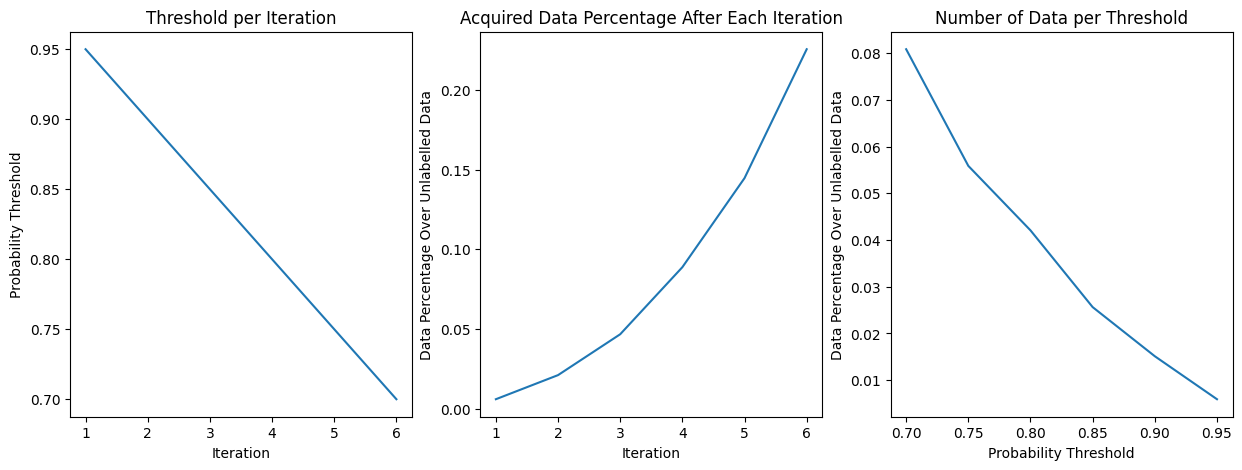

In [147]:
## visualize pseudolabelling results
temp_list = dict(sorted(threshold_iteration_dict.items()))
plt.figure(figsize=(15, 5))
a, b, c = zip(*temp_list.values())

plt.subplot(1, 3, 1)
plt.plot(temp_list.keys(), a)
plt.xlabel("Iteration")
plt.ylabel("Probability Threshold")
plt.title("Threshold per Iteration")

plt.subplot(1, 3, 2)
plt.plot(temp_list.keys(), b)
plt.xlabel("Iteration")
plt.ylabel("Data Percentage Over Unlabelled Data")
plt.title("Acquired Data Percentage After Each Iteration")

a = list(threshold_acc_dict.values())
a = [a/psd_test_size for a in a]
plt.subplot(1, 3, 3)
plt.plot(threshold_acc_dict.keys(), a)
plt.xlabel("Probability Threshold")
plt.ylabel("Data Percentage Over Unlabelled Data")
plt.title("Number of Data per Threshold")
plt.show()

In [148]:
print('================================================================')
print('Threshold per Iteration')
print(threshold_iteration_dict)
print()

print('Number of Data per Threshold')
print(threshold_acc_dict)
print('================================================================')

Threshold per Iteration
{1: (0.95, 0.005917159763313609, 9), 2: (0.8999999999999999, 0.0210387902695595, 32), 3: (0.8499999999999999, 0.04667981591058514, 71), 4: (0.7999999999999998, 0.08875739644970414, 135), 5: (0.7499999999999998, 0.14464168310322156, 220), 6: (0.6999999999999997, 0.2255095332018409, 343)}

Number of Data per Threshold
{0.95: 9, 0.8999999999999999: 23, 0.8499999999999999: 39, 0.7999999999999998: 64, 0.7499999999999998: 85, 0.6999999999999997: 123}


In [149]:
## slice data for EMITEN
news_data = pseudolabelled_news_all.iloc[psd_train_size:].sort_values(by=['published date'], ascending=False)
news_data.reset_index(drop=True, inplace=True)

## save data
news_data.to_csv(f"Labelled News Data/Labelled_News_{EMITEN}.csv")
news_data

,title,sentiment,kode_emiten,cleaned,description,published date,url,publisher,keywords,content,published_date,kode_emitten
0,Sumber Global Energy (SGER) Akan Bagikan Divid...,2.0,NaN,sumber global energy sger bagi dividen saham s...,Sumber Global Energy (SGER) Akan Bagikan Divid...,2023-09-25,https://news.google.com/rss/articles/CBMiZ2h0d...,"{'href': 'https://investor.id', 'title': 'Inve...",Missing,Missing,NaN,NaN
1,Mengubur Kesan Invasi pada Investasi Pertamban...,1.0,NaN,kubur kesan invasi investasi tambang,Mengubur Kesan Invasi pada Investasi Pertamban...,2023-09-23,https://news.google.com/rss/articles/CBMiZGh0d...,"{'href': 'https://investor.id', 'title': 'Inve...",Missing,Missing,NaN,NaN
2,Sumber Global Energy (SGER) Mau Bagi-bagi Divi...,2.0,NaN,sumber global energy sger bagibagi dividen saham,Sumber Global Energy (SGER) Mau Bagi-bagi Divi...,2023-09-21,https://news.google.com/rss/articles/CBMiVmh0d...,"{'href': 'https://investor.id', 'title': 'Inve...",Missing,Missing,NaN,NaN
3,"Margin Diramal Membaik, Saham MBMA dan NCKL Ja...",2.0,NaN,margin ramal baik saham mbma nckl top picks se...,"Margin Diramal Membaik, Saham MBMA dan NCKL Ja...",2023-09-18,https://news.google.com/rss/articles/CBMid2h0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['margin', 'produksi', 'logam', 'tambang', 'to...",ILUSTRASI. Fasilitas pengolahan nikel PT Trime...,NaN,NaN
4,"Prediksi IHSG Besok Jelang FOMC, Rekomendasi S...",2.0,NaN,prediksi ihsg besok jelang fomc rekomendasi sa...,"Prediksi IHSG Besok Jelang FOMC, Rekomendasi S...",2023-09-18,https://news.google.com/rss/articles/CBMicWh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['prediksi', 'rekomendasi', 'fed', 'sekuritas'...",IHSG diprediksi bergerak di rentang 6.889-7.02...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
338,"Pacu 4 Jalan Tol, Citra Marga Nusaphala (CMNP)...",2.0,NaN,pacu jalan tol citra marga nusaphala cmnp siap...,"Pacu 4 Jalan Tol, Citra Marga Nusaphala (CMNP)...",2019-01-22,https://news.google.com/rss/articles/CBMidGh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['triliun', 'tito', 'marga', 'citra', 'nusapha...",PT Citra Marga Nusaphala Persada Tbk. menyiapk...,NaN,NaN
339,PROYEKSI 2019: Indeks Bisnis-27 Berpotensi Reb...,2.0,NaN,proyeksi indeks bisnis potensi rebound,PROYEKSI 2019: Indeks Bisnis-27 Berpotensi Reb...,2019-01-02,https://news.google.com/rss/articles/CBMiYmh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['tingginya', '2019', 'investor', 'rebound', '...",Kinerja Indeks Bisnis-27 sepanjang tahun ini d...,NaN,NaN
340,Sektor finansial dan konstruksi dorong IHSG me...,2.0,NaN,sektor finansial konstruksi dorong ihsg kuat sesi,Sektor finansial dan konstruksi dorong IHSG me...,2018-11-22,https://news.google.com/rss/articles/CBMiZGh0d...,"{'href': 'https://investasi.kontan.co.id', 'ti...","['06', 'rp', 'menguat', 'sanny', 'diikuti', 't...",ILUSTRASI. Bursa Efek Indonesia\r\n\r\nReporte...,NaN,NaN
341,ADRO Targetkan Produksi AMC 1 Juta Ton - Bisni...,1.0,NaN,adro target produksi amc juta ton,ADRO Targetkan Produksi AMC 1 Juta Ton Bisnis...,2018-11-07,https://news.google.com/rss/articles/CBMiWWh0d...,"{'href': 'https://market.bisnis.com', 'title':...","['yoy', 'produksi', 'batu', 'ton', 'bara', 'ad...","Smallest Font Largest Font\r\n\r\nBisnis.com, ...",NaN,NaN


In [150]:
temp = pseudolabelled_news_all.reset_index(drop=True)
temp.to_csv('Labelled News Data\Labelled_News_All.csv')

# Data Fusion of Historical and News Sentiment

## Merging with Outer

In [641]:
EMITEN = 'TLKM'
news_data = pd.read_csv(f'Labelled News Data\Labelled_News_{EMITEN}.csv')
news_data.drop(news_data.columns[0], axis=1, inplace=True)
stock_data = pd.read_csv(f'Labelled Stock Data\Labelled_Stock_{EMITEN}.csv')
stock_data.head()

,datetime,symbol,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,...,MACD,MACD_SIGNAL,UPPERBAND,MIDDLEBAND,LOWERBAND,target_1,target_5,target_10,target_20,target_50
0,2018-07-12,IDX:TLKM,4050.0,4110.0,4040.0,4100.0,114531700.0,4006.0,4008.459941,3882.0,...,94.627636,48.834523,4078.994556,3780.5,3482.005444,sell,sell,hold,sell,sell
1,2018-07-13,IDX:TLKM,4080.0,4100.0,3970.0,4020.0,120850800.0,4038.0,4012.306628,3909.0,...,97.871261,58.641870,4108.265711,3792.0,3475.734289,sell,hold,hold,sell,sell
2,2018-07-16,IDX:TLKM,3970.0,4030.0,3860.0,3940.0,66229700.0,4030.0,3988.204418,3928.0,...,92.915454,65.496587,4123.019767,3800.5,3477.980233,hold,buy,hold,sell,hold
3,2018-07-17,IDX:TLKM,3970.0,3970.0,3890.0,3940.0,53740400.0,4012.0,3972.136279,3952.0,...,87.973833,69.992036,4132.537636,3817.0,3501.462364,buy,hold,sell,sell,hold
4,2018-07-18,IDX:TLKM,3910.0,4030.0,3890.0,4010.0,75157800.0,4002.0,3984.757519,3977.0,...,88.683688,73.730367,4154.217318,3832.0,3509.782682,sell,hold,sell,sell,hold


In [642]:
# Rename columns
news_data.rename(columns={"published date": "datetime"}, inplace=True)

# conform data type
news_data['datetime'] = news_data['datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
stock_data['datetime'] = stock_data['datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d "))

In [643]:
# Merge data
merge_data = pd.merge(news_data, stock_data, on='datetime', how="outer")
merge_data = merge_data.drop(columns=['title', 'description', 'url', 'publisher', 'keywords', 'content', 'cleaned'])
merge_data.sort_values(by=["datetime"], ascending=True, inplace=True)
merge_data.reset_index(inplace=True, drop=True)
merge_data

,datetime,sentiment,symbol,open,high,low,close,volume,SMA_5,EMA_5,...,MACD,MACD_SIGNAL,UPPERBAND,MIDDLEBAND,LOWERBAND,target_1,target_5,target_10,target_20,target_50
0,2018-07-12,NaN,IDX:TLKM,4050.0,4110.0,4040.0,4100.0,114531700.0,4006.0,4008.459941,...,94.627636,48.834523,4078.994556,3780.5,3482.005444,sell,sell,hold,sell,sell
1,2018-07-13,NaN,IDX:TLKM,4080.0,4100.0,3970.0,4020.0,120850800.0,4038.0,4012.306628,...,97.871261,58.641870,4108.265711,3792.0,3475.734289,sell,hold,hold,sell,sell
2,2018-07-16,NaN,IDX:TLKM,3970.0,4030.0,3860.0,3940.0,66229700.0,4030.0,3988.204418,...,92.915454,65.496587,4123.019767,3800.5,3477.980233,hold,buy,hold,sell,hold
3,2018-07-17,NaN,IDX:TLKM,3970.0,3970.0,3890.0,3940.0,53740400.0,4012.0,3972.136279,...,87.973833,69.992036,4132.537636,3817.0,3501.462364,buy,hold,sell,sell,hold
4,2018-07-18,NaN,IDX:TLKM,3910.0,4030.0,3890.0,4010.0,75157800.0,4002.0,3984.757519,...,88.683688,73.730367,4154.217318,3832.0,3509.782682,sell,hold,sell,sell,hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,2023-11-29,NaN,IDX:TLKM,3750.0,3770.0,3700.0,3720.0,56467400.0,3678.0,3690.138526,...,15.276767,-11.869355,3730.733317,3594.0,3457.266683,hold,NaN,NaN,NaN,NaN
4115,2023-11-30,NaN,IDX:TLKM,3750.0,3820.0,3740.0,3760.0,258522400.0,3710.0,3713.425684,...,23.724146,-4.750655,3755.518607,3601.0,3446.481393,buy,NaN,NaN,NaN,NaN
4116,2023-12-01,NaN,IDX:TLKM,3790.0,3840.0,3790.0,3830.0,81037200.0,3752.0,3752.283789,...,35.656147,3.330706,3797.019125,3614.0,3430.980875,hold,NaN,NaN,NaN,NaN
4117,2023-12-04,NaN,IDX:TLKM,3840.0,3860.0,3780.0,3810.0,118542300.0,3778.0,3771.522526,...,43.002802,11.265125,3823.653168,3622.0,3420.346832,hold,NaN,NaN,NaN,NaN


## Agregate Sentiment

In [644]:
temp_2 = merge_data[["datetime", "sentiment"]]
temp_2 = temp_2.groupby(["datetime", "sentiment"]).size().to_frame("agg")
temp_2 = temp_2.pivot_table(values="agg", index=["datetime"], columns="sentiment")
temp_2.reset_index(inplace=True)
temp_2

sentiment,datetime,negative,positive
0,2018-10-22,NaN,1.0
1,2018-10-23,NaN,1.0
2,2018-10-24,NaN,3.0
3,2018-10-26,NaN,1.0
4,2018-10-29,1.0,1.0
...,...,...,...
1391,2023-09-20,NaN,6.0
1392,2023-09-21,1.0,NaN
1393,2023-09-22,NaN,3.0
1394,2023-09-23,NaN,1.0


In [645]:
merge_data.drop_duplicates(subset='datetime', keep="first", inplace=True)
merge_data.drop(columns=["sentiment"], inplace=True)
merge_data.reset_index(inplace=True, drop=True)
merge_data = pd.merge(merge_data, temp_2, on='datetime', how='left')
merge_data

,datetime,symbol,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,...,UPPERBAND,MIDDLEBAND,LOWERBAND,target_1,target_5,target_10,target_20,target_50,negative,positive
0,2018-07-12,IDX:TLKM,4050.0,4110.0,4040.0,4100.0,114531700.0,4006.0,4008.459941,3882.0,...,4078.994556,3780.5,3482.005444,sell,sell,hold,sell,sell,NaN,NaN
1,2018-07-13,IDX:TLKM,4080.0,4100.0,3970.0,4020.0,120850800.0,4038.0,4012.306628,3909.0,...,4108.265711,3792.0,3475.734289,sell,hold,hold,sell,sell,NaN,NaN
2,2018-07-16,IDX:TLKM,3970.0,4030.0,3860.0,3940.0,66229700.0,4030.0,3988.204418,3928.0,...,4123.019767,3800.5,3477.980233,hold,buy,hold,sell,hold,NaN,NaN
3,2018-07-17,IDX:TLKM,3970.0,3970.0,3890.0,3940.0,53740400.0,4012.0,3972.136279,3952.0,...,4132.537636,3817.0,3501.462364,buy,hold,sell,sell,hold,NaN,NaN
4,2018-07-18,IDX:TLKM,3910.0,4030.0,3890.0,4010.0,75157800.0,4002.0,3984.757519,3977.0,...,4154.217318,3832.0,3509.782682,sell,hold,sell,sell,hold,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,2023-11-29,IDX:TLKM,3750.0,3770.0,3700.0,3720.0,56467400.0,3678.0,3690.138526,3630.0,...,3730.733317,3594.0,3457.266683,hold,NaN,NaN,NaN,NaN,NaN,NaN
1632,2023-11-30,IDX:TLKM,3750.0,3820.0,3740.0,3760.0,258522400.0,3710.0,3713.425684,3652.0,...,3755.518607,3601.0,3446.481393,buy,NaN,NaN,NaN,NaN,NaN,NaN
1633,2023-12-01,IDX:TLKM,3790.0,3840.0,3790.0,3830.0,81037200.0,3752.0,3752.283789,3680.0,...,3797.019125,3614.0,3430.980875,hold,NaN,NaN,NaN,NaN,NaN,NaN
1634,2023-12-04,IDX:TLKM,3840.0,3860.0,3780.0,3810.0,118542300.0,3778.0,3771.522526,3702.0,...,3823.653168,3622.0,3420.346832,hold,NaN,NaN,NaN,NaN,NaN,NaN


## Aggregate Data Holidays

In [646]:
values = {"negative": 0, "positive": 0}
merge_data.fillna(value = values, inplace=True)

# Add values from holiday dates to business dates
holidays = merge_data[merge_data["symbol"].isnull()].index
for ind in holidays:
    i = 1
    while(pd.isnull(merge_data.loc[ind + i, "symbol"])):
        i += 1
    merge_data.loc[ind + i, "negative"] += merge_data.loc[ind, "negative"]
    merge_data.loc[ind + i, "positive"] += merge_data.loc[ind, "positive"]
    merge_data.drop([ind], axis=0, inplace=True)

merge_data.reset_index(inplace=True, drop=True)
merge_data["total_news"] = merge_data["negative"] + merge_data["positive"]
merge_data

,datetime,symbol,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,...,MIDDLEBAND,LOWERBAND,target_1,target_5,target_10,target_20,target_50,negative,positive,total_news
0,2018-07-12,IDX:TLKM,4050.0,4110.0,4040.0,4100.0,114531700.0,4006.0,4008.459941,3882.0,...,3780.5,3482.005444,sell,sell,hold,sell,sell,0.0,0.0,0.0
1,2018-07-13,IDX:TLKM,4080.0,4100.0,3970.0,4020.0,120850800.0,4038.0,4012.306628,3909.0,...,3792.0,3475.734289,sell,hold,hold,sell,sell,0.0,0.0,0.0
2,2018-07-16,IDX:TLKM,3970.0,4030.0,3860.0,3940.0,66229700.0,4030.0,3988.204418,3928.0,...,3800.5,3477.980233,hold,buy,hold,sell,hold,0.0,0.0,0.0
3,2018-07-17,IDX:TLKM,3970.0,3970.0,3890.0,3940.0,53740400.0,4012.0,3972.136279,3952.0,...,3817.0,3501.462364,buy,hold,sell,sell,hold,0.0,0.0,0.0
4,2018-07-18,IDX:TLKM,3910.0,4030.0,3890.0,4010.0,75157800.0,4002.0,3984.757519,3977.0,...,3832.0,3509.782682,sell,hold,sell,sell,hold,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,2023-11-29,IDX:TLKM,3750.0,3770.0,3700.0,3720.0,56467400.0,3678.0,3690.138526,3630.0,...,3594.0,3457.266683,hold,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1315,2023-11-30,IDX:TLKM,3750.0,3820.0,3740.0,3760.0,258522400.0,3710.0,3713.425684,3652.0,...,3601.0,3446.481393,buy,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1316,2023-12-01,IDX:TLKM,3790.0,3840.0,3790.0,3830.0,81037200.0,3752.0,3752.283789,3680.0,...,3614.0,3430.980875,hold,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1317,2023-12-04,IDX:TLKM,3840.0,3860.0,3780.0,3810.0,118542300.0,3778.0,3771.522526,3702.0,...,3622.0,3420.346832,hold,NaN,NaN,NaN,NaN,0.0,0.0,0.0


## Apply Final Sentiment

In [647]:
merge_data["sentiment"] = merge_data.apply(lambda x: apply_sentiment(x), axis=1)
merge_data

,datetime,symbol,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,...,LOWERBAND,target_1,target_5,target_10,target_20,target_50,negative,positive,total_news,sentiment
0,2018-07-12,IDX:TLKM,4050.0,4110.0,4040.0,4100.0,114531700.0,4006.0,4008.459941,3882.0,...,3482.005444,sell,sell,hold,sell,sell,0.0,0.0,0.0,no sentiment
1,2018-07-13,IDX:TLKM,4080.0,4100.0,3970.0,4020.0,120850800.0,4038.0,4012.306628,3909.0,...,3475.734289,sell,hold,hold,sell,sell,0.0,0.0,0.0,no sentiment
2,2018-07-16,IDX:TLKM,3970.0,4030.0,3860.0,3940.0,66229700.0,4030.0,3988.204418,3928.0,...,3477.980233,hold,buy,hold,sell,hold,0.0,0.0,0.0,no sentiment
3,2018-07-17,IDX:TLKM,3970.0,3970.0,3890.0,3940.0,53740400.0,4012.0,3972.136279,3952.0,...,3501.462364,buy,hold,sell,sell,hold,0.0,0.0,0.0,no sentiment
4,2018-07-18,IDX:TLKM,3910.0,4030.0,3890.0,4010.0,75157800.0,4002.0,3984.757519,3977.0,...,3509.782682,sell,hold,sell,sell,hold,0.0,0.0,0.0,no sentiment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,2023-11-29,IDX:TLKM,3750.0,3770.0,3700.0,3720.0,56467400.0,3678.0,3690.138526,3630.0,...,3457.266683,hold,NaN,NaN,NaN,NaN,0.0,0.0,0.0,no sentiment
1315,2023-11-30,IDX:TLKM,3750.0,3820.0,3740.0,3760.0,258522400.0,3710.0,3713.425684,3652.0,...,3446.481393,buy,NaN,NaN,NaN,NaN,0.0,0.0,0.0,no sentiment
1316,2023-12-01,IDX:TLKM,3790.0,3840.0,3790.0,3830.0,81037200.0,3752.0,3752.283789,3680.0,...,3430.980875,hold,NaN,NaN,NaN,NaN,0.0,0.0,0.0,no sentiment
1317,2023-12-04,IDX:TLKM,3840.0,3860.0,3780.0,3810.0,118542300.0,3778.0,3771.522526,3702.0,...,3420.346832,hold,NaN,NaN,NaN,NaN,0.0,0.0,0.0,no sentiment


## Sentiment Visualization

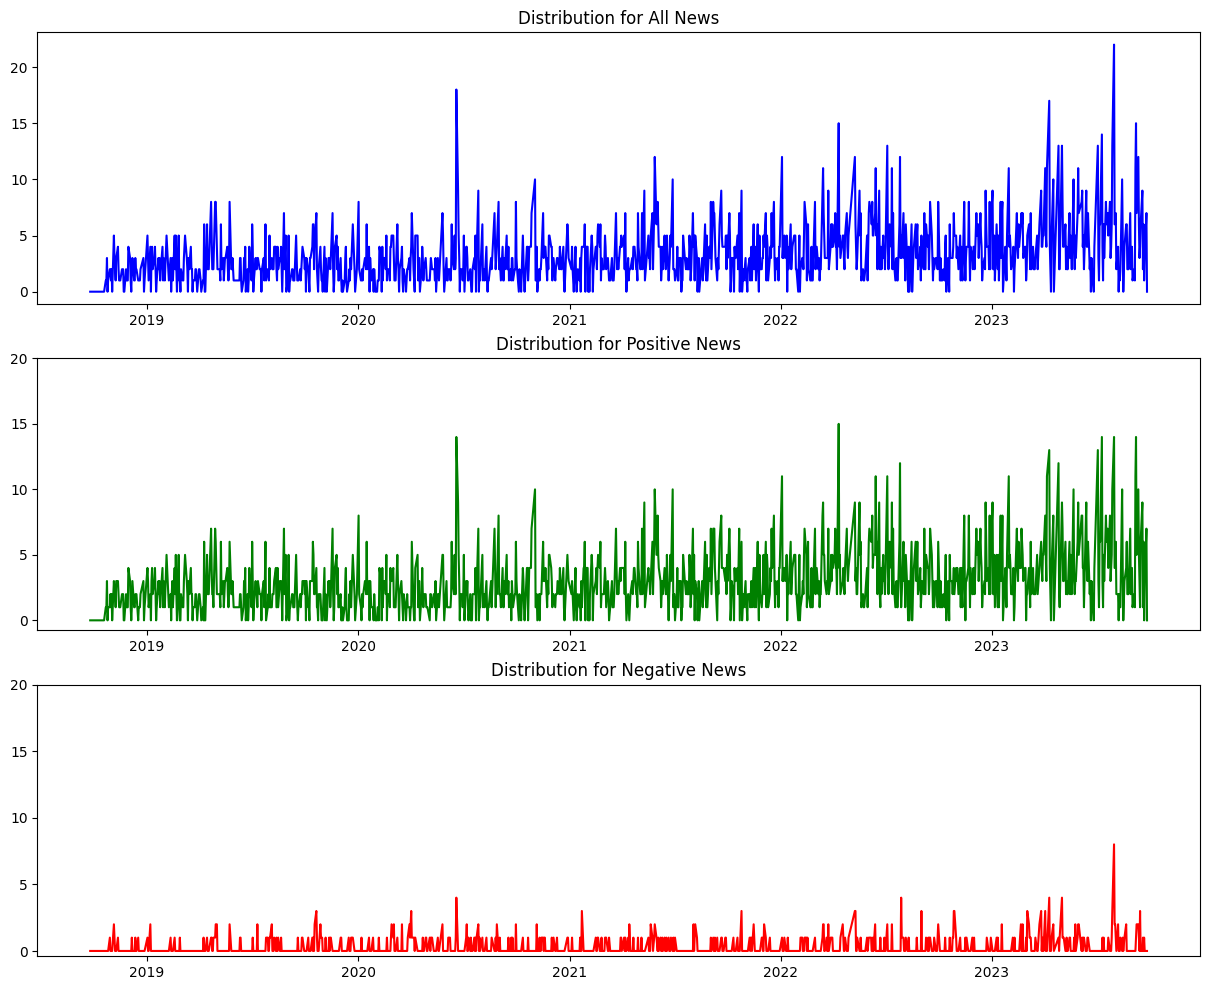

In [648]:
plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
plt.plot(merge_data.loc[50:merge_data.shape[0]-50, 'datetime'], merge_data.loc[50:merge_data.shape[0]-50, 'total_news'], color='blue')
plt.yticks(np.arange(0, merge_data['total_news'].max() + 1, 5))
plt.title('Distribution for All News')

plt.subplot(3, 1, 2)
plt.plot(merge_data.loc[50:merge_data.shape[0]-50, 'datetime'], merge_data.loc[50:merge_data.shape[0]-50, 'positive'], color='green')
plt.yticks(np.arange(0, merge_data['total_news'].max() + 1, 5))
plt.title('Distribution for Positive News')


plt.subplot(3, 1, 3)
plt.plot(merge_data.loc[50:merge_data.shape[0]-50, 'datetime'], merge_data.loc[50:merge_data.shape[0]-50, 'negative'], color='red')
plt.yticks(np.arange(0, merge_data['total_news'].max() + 1, 5))
plt.title('Distribution for Negative News')

plt.show()

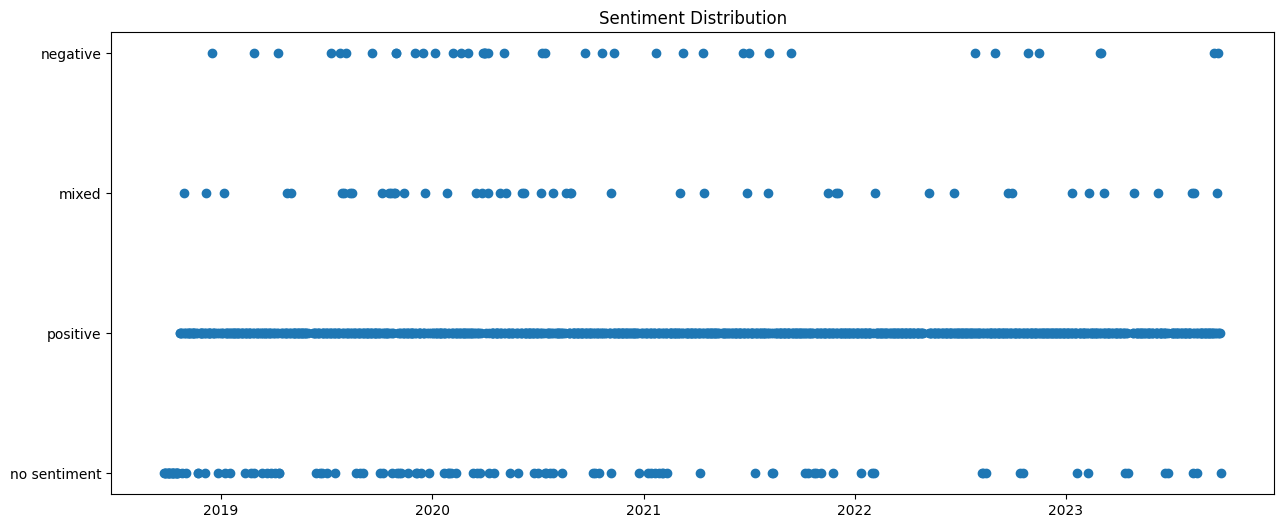

In [649]:
plt.figure(figsize=(15, 6))

plt.scatter(merge_data.loc[50:merge_data.shape[0]-50, 'datetime'], merge_data.loc[50:merge_data.shape[0]-50, 'sentiment'])
plt.title('Sentiment Distribution')
plt.show()

In [650]:
merge_data.loc[:, 'sentiment'].value_counts()

sentiment
positive        1016
no sentiment     212
mixed             50
negative          41
Name: count, dtype: int64

## Label Encoding for Final Sentiment and Buy/Sell Label

In [651]:
le = LabelEncoder()
le.classes_ = np.array(["negative", "no sentiment", "mixed", "positive"])
merge_data["sentiment"] = le.transform(merge_data["sentiment"]) - 1

merge_data = merge_data.iloc[:-50]
target_columns = ['target_1',
                  'target_5',
                  'target_10',
                  'target_20',
                  'target_50']
le.classes_ = np.array(["sell", "hold", "buy"])
for col in target_columns:
    merge_data.loc[:, col] = le.transform(merge_data.loc[:, col])

try:
    os.makedirs(f"Data Fusion of Historical and Sentiment")
except Exception:
    pass
merge_data.to_csv(f"Data Fusion of Historical and Sentiment\Fusion_Data_{EMITEN}.csv", index=False)

# Modelling

## Split Features and Target

In [858]:
EMITEN = 'INCO'
TARGET_DAY = 20
fusion_data = pd.read_csv(f'Data Fusion of Historical and Sentiment\Fusion_Data_{EMITEN}.csv')
fusion_data

,datetime,symbol,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,...,LOWERBAND,target_1,target_5,target_10,target_20,target_50,negative,positive,total_news,sentiment
0,2018-07-12,IDX:INCO,4223.38488,4282.45320,4134.78240,4134.78240,1.097096e+07,4054.055696,4085.980288,4034.366256,...,3813.028825,2,2,1,1,0,0.0,0.0,0.0,0
1,2018-07-13,IDX:INCO,4184.00600,4430.12400,4184.00600,4430.12400,1.543233e+07,4140.689232,4200.694858,4079.651968,...,3767.830556,1,0,1,1,0,0.0,0.0,0.0,0
2,2018-07-16,IDX:INCO,4469.50288,4577.79480,4410.43456,4410.43456,9.484069e+06,4231.260656,4270.608092,4119.030848,...,3737.718921,0,0,1,1,0,0.0,0.0,0.0,0
3,2018-07-17,IDX:INCO,4380.90040,4390.74512,4252.91904,4282.45320,4.593325e+06,4294.266864,4274.556462,4151.518424,...,3730.867883,1,1,1,0,0,0.0,0.0,0.0,0
4,2018-07-18,IDX:INCO,4282.45320,4351.36624,4262.76376,4282.45320,6.116781e+06,4308.049472,4277.188708,4179.083640,...,3736.243999,1,1,1,1,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,2023-09-19,IDX:INCO,5832.99660,5832.99660,5636.10220,5660.71400,6.861749e+06,5749.316480,5748.868959,5791.156540,...,5694.924625,1,0,1,1,0,0.0,1.0,1.0,2
1265,2023-09-20,IDX:INCO,5660.71400,5759.16120,5636.10220,5636.10220,8.668301e+06,5734.549400,5711.280039,5764.083560,...,5660.714000,1,1,0,1,0,0.0,2.0,2.0,2
1266,2023-09-21,IDX:INCO,5660.71400,5685.32580,5562.26680,5586.87860,7.978185e+06,5700.092880,5669.812893,5732.088220,...,5619.547893,1,1,1,1,0,0.0,5.0,5.0,2
1267,2023-09-22,IDX:INCO,5586.87860,5660.71400,5562.26680,5611.49040,5.104259e+06,5660.714000,5650.372062,5714.859960,...,5591.148751,1,1,1,1,0,0.0,2.0,2.0,2


In [859]:
x = fusion_data.copy()
target_columns = ['target_1',
                  'target_5',
                  'target_10',
                  'target_20',
                  'target_50']
y = x[target_columns]

x.drop([
        'symbol',
        ], axis=1, inplace=True)

for col in target_columns:
    print(x[col].value_counts())
    x.drop([col], axis=1, inplace=True)
    
x.set_index("datetime", inplace=True)
x

target_1
1    631
0    334
2    304
Name: count, dtype: int64
target_5
1    524
2    378
0    367
Name: count, dtype: int64
target_10
1    683
2    319
0    267
Name: count, dtype: int64
target_20
1    755
2    307
0    207
Name: count, dtype: int64
target_50
1    541
2    405
0    323
Name: count, dtype: int64


,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,EMA_10,SMA_20,...,RSI,MACD,MACD_SIGNAL,UPPERBAND,MIDDLEBAND,LOWERBAND,negative,positive,total_news,sentiment
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-12,4223.38488,4282.45320,4134.78240,4134.78240,1.097096e+07,4054.055696,4085.980288,4034.366256,4043.943639,4022.552592,...,58.567537,111.811026,119.440053,4232.076359,4022.552592,3813.028825,0.0,0.0,0.0,0
2018-07-13,4184.00600,4430.12400,4184.00600,4430.12400,1.543233e+07,4140.689232,4200.694858,4079.651968,4114.158250,4034.858492,...,66.562199,135.439133,122.639869,4301.886428,4034.858492,3767.830556,0.0,0.0,0.0,0
2018-07-16,4469.50288,4577.79480,4410.43456,4410.43456,9.484069e+06,4231.260656,4270.608092,4119.030848,4168.026670,4050.117808,...,65.652694,150.837049,128.279305,4362.516695,4050.117808,3737.718921,0.0,0.0,0.0,0
2018-07-17,4380.90040,4390.74512,4252.91904,4282.45320,4.593325e+06,4294.266864,4274.556462,4151.518424,4188.831494,4056.516876,...,59.921340,150.972663,132.817976,4382.165869,4056.516876,3730.867883,0.0,0.0,0.0,0
2018-07-18,4282.45320,4351.36624,4262.76376,4282.45320,6.116781e+06,4308.049472,4277.188708,4179.083640,4205.853622,4072.760664,...,59.921340,149.358428,136.126067,4409.277329,4072.760664,3736.243999,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-19,5832.99660,5832.99660,5636.10220,5660.71400,6.861749e+06,5749.316480,5748.868959,5791.156540,5784.662271,5830.535420,...,29.647504,-118.090924,-125.071543,5966.146215,5830.535420,5694.924625,0.0,1.0,1.0,2
2023-09-20,5660.71400,5759.16120,5636.10220,5636.10220,8.668301e+06,5734.549400,5711.280039,5764.083560,5757.651349,5818.229520,...,28.567439,-122.392095,-124.535653,5975.745040,5818.229520,5660.714000,0.0,2.0,2.0,2
2023-09-21,5660.71400,5685.32580,5562.26680,5586.87860,7.978185e+06,5700.092880,5669.812893,5732.088220,5726.601758,5803.462440,...,26.488979,-128.293846,-125.287292,5987.376987,5803.462440,5619.547893,0.0,5.0,5.0,2


## Split Train/Test

In [860]:
x_copy = x.copy()

x = x.iloc[50:]
y = y.iloc[50:]

# training_size = int((x.shape[0]) * 0.8)

# x_train = x.iloc[:training_size]
# y_train = y.iloc[:training_size]

# x_test = x.iloc[training_size:]
# y_test = y.iloc[training_size:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

print(f"Training Size: {x_train.shape[0]}")
print(f"Test Size: {x_test.shape[0]}")
x_train

Training Size: 975
Test Size: 244


,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,EMA_10,SMA_20,...,RSI,MACD,MACD_SIGNAL,UPPERBAND,MIDDLEBAND,LOWERBAND,negative,positive,total_news,sentiment
datetime,,,,,,,,,,,,,,,,,,,,,
2022-06-08,7580.43440,7580.43440,7383.54000,7580.43440,1.286060e+07,7595.201480,7602.406201,7686.265140,7600.407840,7387.231770,...,53.206046,154.718245,179.903312,8269.869391,7387.231770,6504.594149,0.0,2.0,2.0,2
2020-12-18,5316.14880,5463.81960,5242.31340,5291.53700,2.534211e+07,5276.769920,5256.578066,5133.529244,5136.690560,4873.874754,...,71.326662,260.602417,231.451582,5471.654997,4873.874754,4276.094511,0.0,0.0,0.0,0
2022-06-13,7088.19840,7137.42200,6891.30400,7088.19840,2.169132e+07,7403.229440,7349.942045,7587.817940,7451.950302,7461.067170,...,43.895469,62.235753,139.215459,8210.378261,7461.067170,6711.756079,0.0,3.0,3.0,2
2022-12-30,7088.19840,7088.19840,6989.75120,6989.75120,2.381683e+06,7014.363000,7022.965203,7053.741880,7051.351125,7118.963150,...,46.680970,-3.246895,26.441155,7332.887692,7118.963150,6905.038608,0.0,0.0,0.0,0
2020-06-17,2973.10544,3012.48432,2874.65824,2992.79488,1.666142e+07,2849.061968,2891.769074,2876.627184,2871.781395,2869.243644,...,59.231292,63.060415,77.413132,3032.259247,2869.243644,2706.228041,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,4764.84448,4774.68920,4745.15504,4764.84448,2.554974e+06,4751.061872,4754.432491,4735.310320,4756.613437,4816.775378,...,48.628105,-18.273727,-15.797331,5044.813500,4816.775378,4588.737256,1.0,4.0,5.0,2
2022-02-22,4823.91280,4922.36000,4764.84448,4882.98112,2.255046e+07,4772.720256,4793.249762,4710.698520,4741.623761,4686.086720,...,62.564772,37.291770,15.886966,4852.808732,4686.086720,4519.364708,0.0,2.0,2.0,2
2023-09-21,5660.71400,5685.32580,5562.26680,5586.87860,7.978185e+06,5700.092880,5669.812893,5732.088220,5726.601758,5803.462440,...,26.488979,-128.293846,-125.287292,5987.376987,5803.462440,5619.547893,0.0,5.0,5.0,2


## Feature Scaling

In [861]:
scaler = StandardScaler()
x_train = scaler.fit_transform(np.array(x_train))
x_test = scaler.transform(np.array(x_test))
x_train

array([[ 1.90454133,  1.82715596,  1.86766144, ...,  0.5205906 ,
         0.42948431,  0.96270715],
       [ 0.41833741,  0.45683557,  0.43530473, ..., -0.6879233 ,
        -0.69921435, -0.9766306 ],
       [ 1.58145352,  1.54034472,  1.53838403, ...,  1.12484755,
         0.99383365,  0.96270715],
       ...,
       [ 0.64449888,  0.60024119,  0.64933504, ...,  2.33336145,
         2.12253231,  0.96270715],
       [ 0.96758668,  1.15792972,  0.96214858, ..., -0.6879233 ,
        -0.69921435, -0.9766306 ],
       [ 0.35371985,  0.39309973,  0.40237699, ..., -0.08366635,
        -0.13486502,  0.96270715]])

## PCA

In [862]:
pca = PCA()
pca.fit(np.array(x_train))
print(np.cumsum(pca.explained_variance_ratio_))
n_comp = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95) + 1
print(f'pca dimensions: {n_comp}')

pca = PCA(n_components=n_comp)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
x_train[:5]

[0.6716712  0.7997178  0.8779482  0.92381541 0.96232944 0.98011263
 0.99507147 0.99722293 0.99930116 0.99967035 0.99978808 0.99985227
 0.9999081  0.99995279 0.99997558 0.99999369 0.99999837 0.99999993
 1.         1.         1.         1.         1.        ]
pca dimensions: 5


array([[ 7.32252697,  0.8565652 , -0.29470361, -0.45560014, -0.89949191],
       [ 0.86040711,  3.20643146, -0.29462417,  0.30145933, -0.29872343],
       [ 7.05593824, -0.25199935,  0.00890569, -0.61306034, -0.26208474],
       [ 5.66541777,  0.20270607, -2.68179482,  0.55634776, -1.03432241],
       [-4.72318515,  1.30487753,  0.19705787,  0.19940588, -0.15465396]])

## Create Sliding Window

In [863]:
data_size = x_copy.shape[0]
window_size = TARGET_DAY
new_x = []

for i in range(data_size - window_size + 1):
    new_x.append(x_copy[i:i + window_size])
new_x = np.array(new_x)[50+1 - window_size:]
new_x
new_x.shape

(1219, 10, 23)

## Apply Sliding Window to With Feature Scaling and PCA

In [864]:
new_x_pca = np.zeros((new_x.shape[0], window_size, n_comp))

for i in range(new_x.shape[0]):
        new_x[i] = scaler.transform(new_x[i])
        new_x_pca[i] = pca.transform(new_x[i])
    
new_x = new_x[:, :].reshape(new_x.shape[0], -1)
new_x_pca = new_x_pca[:, :].reshape(new_x_pca.shape[0], -1)

x_train, x_test = train_test_split(new_x_pca, test_size=0.2, random_state=0)
# x_train = new_x_pca[:training_size]
# x_test = new_x_pca[training_size:]

print(x_train.shape)
x_train

(975, 50)


array([[ 6.79818144,  1.84839493, -1.61935448, ..., -0.29470361,
        -0.45560014, -0.89949191],
       [ 0.08641334,  1.9175023 ,  1.22393594, ..., -0.29462417,
         0.30145933, -0.29872343],
       [ 7.44900515,  1.64459229, -0.05679725, ...,  0.00890569,
        -0.61306034, -0.26208474],
       ...,
       [ 3.24291232, -2.33489291, -0.72290254, ...,  1.2027039 ,
        -0.67411238, -0.2480652 ],
       [ 1.32816912,  1.76958376,  1.47398044, ..., -0.35017047,
        -0.15527609,  1.90119182],
       [-0.2933693 , -0.31185635,  0.22627815, ...,  0.83241876,
        -0.77537931,  0.37702894]])

In [865]:
new_x.shape

(1219, 230)

## Model Training and Predicting

In [866]:
# TARGET_DAY = 10
all_results = []
train_target = y_train[f'target_{TARGET_DAY}']
test_target = y_test[f'target_{TARGET_DAY}']
if test_target.nunique() == 3:
    disp_labels = ["sell", "hold", "buy"]
elif test_target.nunique() == 2:
    disp_labels = ["sell", "buy"]
else:
    disp_labels = ["strong sell", "weak sell", "weak buy", "strong buy"]

# proba_thres = 0.6
model_list = [('rf', RandomForestClassifier(random_state=0)),
            ('ad', AdaBoostClassifier(random_state=0)),
            ('xg', XGBClassifier(random_state=0)),
            ('sv', SVC(random_state=0)),
            ('kn', KNeighborsClassifier())]

## (acc, f1, prec, rec)
scores_dict = {}
estimators  = []
estimators_count = 2
accuracy_scores = []
pred_proba = []
all_pred = []

for mod in model_list:
    mod_name = mod[0]
    if mod_name == 'kn':
        results = {}
        for k in range(1, 102):
            classifier = KNeighborsClassifier(n_neighbors=k)
            classifier.fit(x_train, train_target)
            results[k] = classifier.score(x_test, test_target)
        results = sorted(results.items(), key=lambda item: item[1], reverse=True)
        k_effective = results[0][0]
        classifier = KNeighborsClassifier(n_neighbors=k_effective)
        mod_name = mod_name + f'_{k_effective}'
    else:
        classifier = mod[1]
    
    classifier.fit(x_train, train_target)
    y_pred = classifier.predict(x_test)
    # y_proba = classifier.predict_proba(x_test)
    # for i in range(len(y_proba)):
    #     if y_proba[i][1] > proba_thres:
    #         y_pred[i] = 1
    #     else:
    #         y_pred[i] = 0
    # pred_proba.append((mod_name, y_proba))
    all_pred.append((mod_name, y_pred))
    scores_dict[mod_name] = (accuracy_score(test_target, y_pred),
                            classification_report(test_target, y_pred, zero_division=0, target_names=disp_labels, digits=4),
                            confusion_matrix(test_target, y_pred),
                            y_pred, )
    accuracy_scores.append((mod_name, classifier, scores_dict[mod_name][0]))  

accuracy_scores = sorted(accuracy_scores, key=lambda x: x[2], reverse=True)
for i in range(estimators_count):
    estimators.append((accuracy_scores[i][0], accuracy_scores[i][1]))

classifier = VotingClassifier(estimators=estimators, voting='hard')
classifier.fit(x_train, train_target)
y_pred = classifier.predict(x_test)
# y_proba = classifier.predict_proba(x_test)
# for i in range(len(y_proba)):
#         if y_proba[i][1] > proba_thres:
#             y_pred[i] = 1
#         else:
#             y_pred[i] = 0
# pred_proba.append(('vt', y_proba))
all_pred.append(('vt', y_pred))

scores_dict['vt'] = (accuracy_score(test_target, y_pred),
                    classification_report(test_target, y_pred, zero_division=0, target_names=disp_labels, digits=4),
                    confusion_matrix(test_target, y_pred))

all_results.append((EMITEN, scores_dict, all_pred, test_target))

C:\Users\admin\anaconda3\envs\riset-saham-2024\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


# Model Evaluation

## Best Accuracy

In [867]:
[mod[0] for mod in accuracy_scores]

['rf', 'kn_6', 'xg', 'sv', 'ad']

## Classification Report

In [868]:
for key, val in scores_dict.items():
    print(f'======================= {key.upper()} Score =======================')
    print(val[1])

======================= RF Score =======================
              precision    recall  f1-score   support

        sell     0.6364    0.2857    0.3944        49
        hold     0.6170    0.8855    0.7273       131
         buy     0.7353    0.3906    0.5102        64

    accuracy                         0.6352       244
   macro avg     0.6629    0.5206    0.5439       244
weighted avg     0.6519    0.6352    0.6035       244

======================= AD Score =======================
              precision    recall  f1-score   support

        sell     0.4828    0.2857    0.3590        49
        hold     0.5951    0.7405    0.6599       131
         buy     0.5000    0.4062    0.4483        64

    accuracy                         0.5615       244
   macro avg     0.5260    0.4775    0.4890       244
weighted avg     0.5476    0.5615    0.5439       244

======================= XG Score =======================
              precision    recall  f1-score   support

        sell

## Confusion Matrix

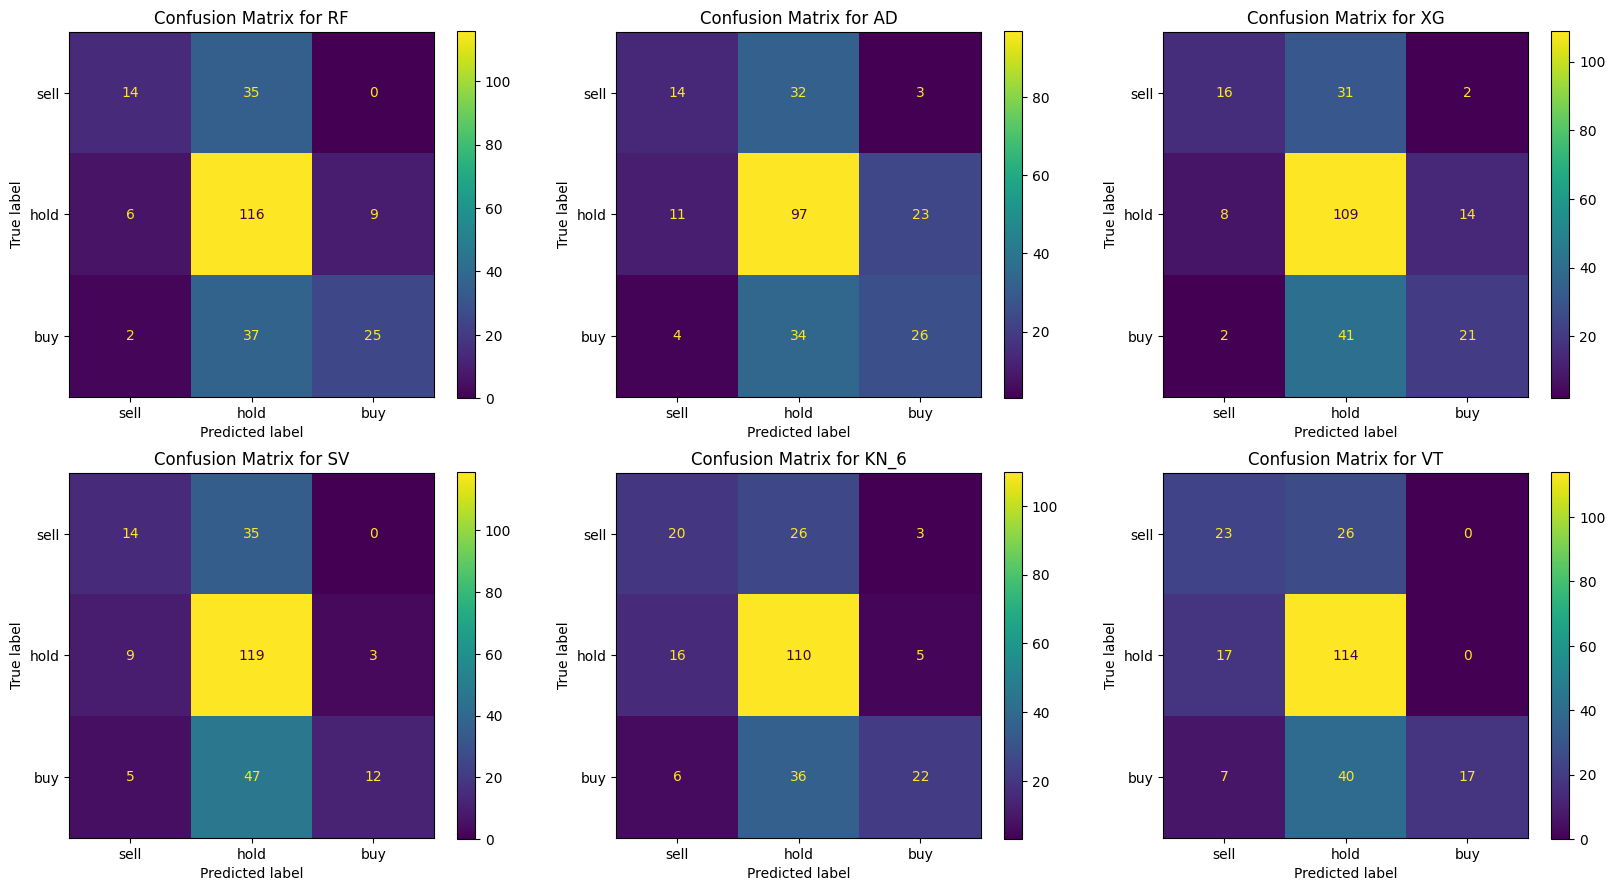

In [869]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10.5))
i = 0

for key, val in scores_dict.items():
    ax[int(i/3), i%3].set_title(f'Confusion Matrix for {key.upper()}')
    ConfusionMatrixDisplay(val[2], display_labels=disp_labels).plot(ax=ax[int(i/3), i%3])
    i += 1
    
plt.show()

In [870]:
train_target.value_counts()

target_10
1    530
2    246
0    199
Name: count, dtype: int64

In [871]:
test_target.value_counts()

target_10
1    131
2     64
0     49
Name: count, dtype: int64

In [872]:
train_df, test_df = train_test_split(x, test_size=0.2,  random_state=0)
train_df = train_df.assign(type='train')
train_df = train_df.assign(ground_truth=list(train_target))
train_df = train_df.assign(prediction=np.nan)
test_df = test_df.assign(type='test')
test_df = test_df.assign(ground_truth=list(test_target))
test_df = test_df.assign(prediction=vt_pred)

result_df = pd.concat([train_df, test_df])
result_df.reset_index(inplace=True)
result_df

,datetime,open,high,low,close,volume,SMA_5,EMA_5,SMA_10,EMA_10,...,UPPERBAND,MIDDLEBAND,LOWERBAND,negative,positive,total_news,sentiment,type,ground_truth,prediction
0,2022-06-08,7580.43440,7580.43440,7383.54000,7580.43440,1.286060e+07,7595.201480,7602.406201,7686.265140,7600.407840,...,8269.869391,7387.231770,6504.594149,0.0,2.0,2.0,2,train,0,NaN
1,2020-12-18,5316.14880,5463.81960,5242.31340,5291.53700,2.534211e+07,5276.769920,5256.578066,5133.529244,5136.690560,...,5471.654997,4873.874754,4276.094511,0.0,0.0,0.0,0,train,2,NaN
2,2022-06-13,7088.19840,7137.42200,6891.30400,7088.19840,2.169132e+07,7403.229440,7349.942045,7587.817940,7451.950302,...,8210.378261,7461.067170,6711.756079,0.0,3.0,3.0,2,train,0,NaN
3,2022-12-30,7088.19840,7088.19840,6989.75120,6989.75120,2.381683e+06,7014.363000,7022.965203,7053.741880,7051.351125,...,7332.887692,7118.963150,6905.038608,0.0,0.0,0.0,0,train,1,NaN
4,2020-06-17,2973.10544,3012.48432,2874.65824,2992.79488,1.666142e+07,2849.061968,2891.769074,2876.627184,2871.781395,...,3032.259247,2869.243644,2706.228041,0.0,0.0,0.0,0,train,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,2022-05-09,7088.19840,7309.70460,6817.46860,7063.58660,4.335187e+07,7201.412680,7246.677370,7676.420420,7385.829430,...,8453.829218,7414.304750,6374.780282,2.0,7.0,9.0,2,test,2,0.0
1215,2021-07-14,5168.47800,5266.92520,5070.03080,5168.47800,2.634844e+07,5080.859992,5063.085216,4874.613108,4923.680554,...,5252.738651,4628.741226,4004.743801,0.0,0.0,0.0,0,test,1,1.0
1216,2022-06-28,5783.77300,5832.99660,5513.04320,5734.54940,3.584876e+07,6138.182920,6085.670111,6477.825760,6405.098832,...,8254.574611,6992.212380,5729.850149,0.0,0.0,0.0,0,test,0,0.0
1217,2019-10-30,3662.23584,3721.30416,3652.39112,3701.61472,2.685876e+07,3603.167520,3601.318621,3504.720320,3564.214596,...,3800.545600,3559.850752,3319.155904,0.0,1.0,1.0,2,test,0,1.0


## Saving Result

In [873]:
try:
    os.makedirs(f"Result Machine Learning/{EMITEN}")
except Exception:
    pass
result_df.to_csv(f'Result Machine Learning/{EMITEN}/{EMITEN}_Target_{TARGET_DAY}.csv')

# Visualization

In [207]:
index_emiten = 0
train_vis = x[:training_size]
test_vis = x[training_size:]
new_vis = unsliced_stock_data[-51:].set_index('datetime')
pred = all_results[0][2][5][1]
df_result = test_vis.copy()
df_result = df_result.assign(pred=pred)

## Train/Test Visualization

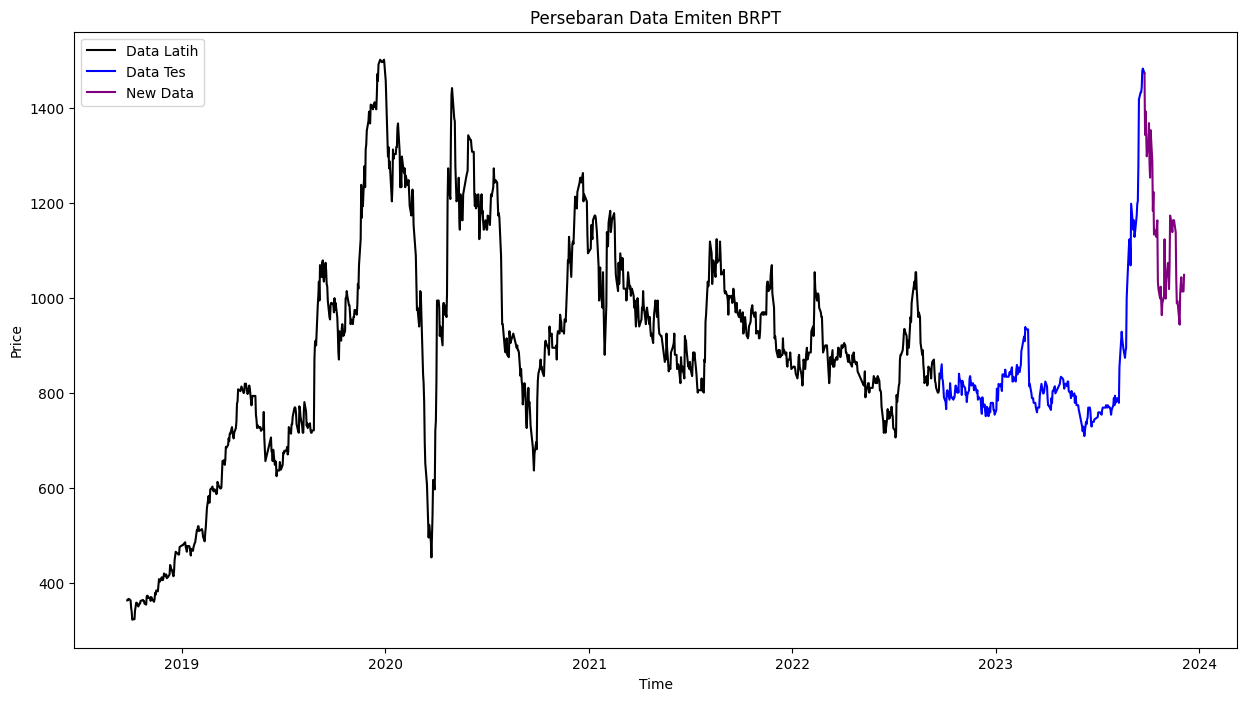

In [208]:
plt.figure(figsize=(15,8))
plt.plot(train_vis.index, train_vis["close"], color='black')
plt.plot(test_vis.index, test_vis["close"], color='blue')
plt.plot(new_vis.index, new_vis["close"], color='purple')
plt.legend(['Data Latih', 'Data Tes', 'New Data'], loc='upper left')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'Persebaran Data Emiten {EMITEN}')
plt.savefig('demo.png', transparent=True)
plt.show()


## Predicted Signals

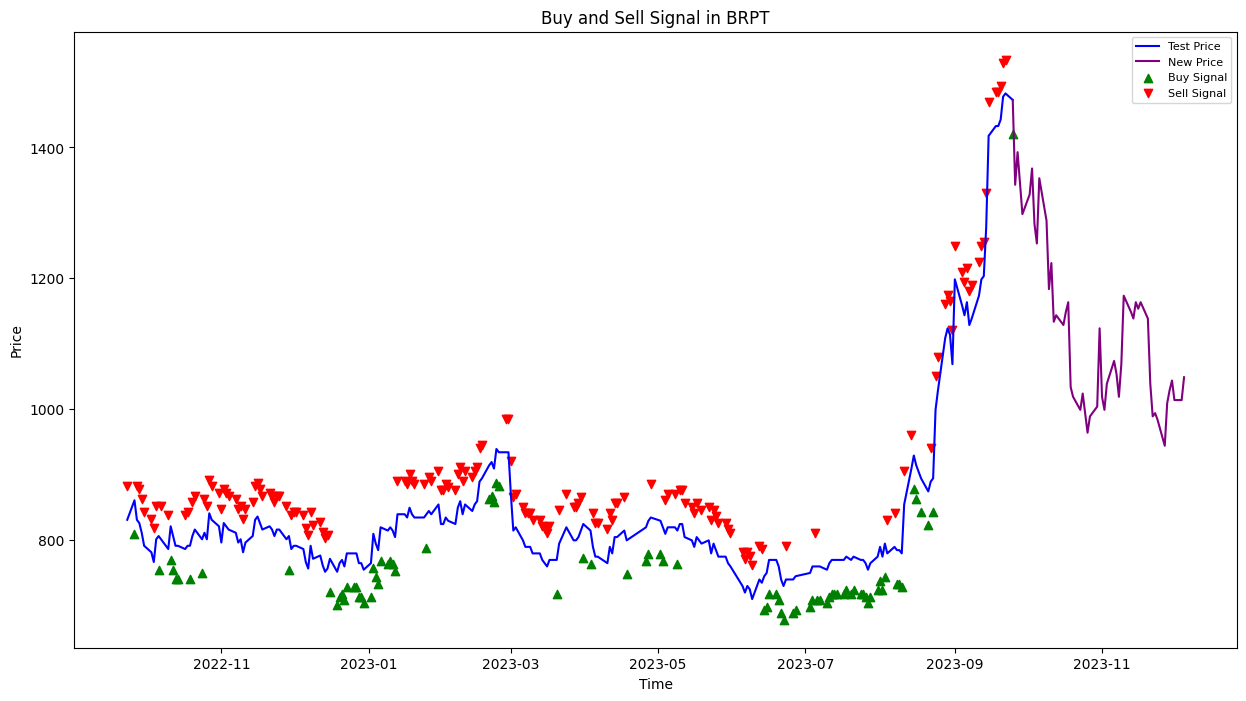

In [210]:
padding = (test_vis['close'].max() - test_vis['close'].min()) / 15

buy_signal = df_result[df_result['pred'] == 1]
sell_signal = df_result[df_result['pred'] == 0]


plt.figure(figsize=(15, 8))
plt.plot(test_vis.index, test_vis["close"], color='blue')
plt.plot(new_vis.index, new_vis["close"], color='purple')
plt.scatter(buy_signal.index, buy_signal["close"] - padding, color='green', marker="^")
plt.scatter(sell_signal.index, sell_signal["close"] + padding, color='red', marker="v")
plt.legend(['Test Price', 'New Price','Buy Signal', 'Sell Signal'], loc='upper right', fontsize=8)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'Buy and Sell Signal in {EMITEN}')
plt.show()

## Profit/Loss Calculations

In [220]:
test_new_df = pd.concat([test_vis, new_vis[1:]])
test_new_df.reset_index(inplace=True)
df_result.reset_index(inplace=True)

init_money = 10000
money = init_money
open_pos = 0
buy_price = 0
sell_price = 0
buy_index_list = []
sell_index_list = []

for i in range(df_result.shape[0]):
    chg = 0
    price = test_new_df.loc[i, 'close']
    if df_result.loc[i, 'pred'] == 1:
        if open_pos == 0:
            buy_price = price
            buy_index = i
            open_pos = 1
            sell_price = 0
            buy_index_list.append(i)

    elif df_result.loc[i, 'pred'] == 0:  
        if open_pos == 1:
            sell_price = price
            chg = (sell_price - buy_price) / buy_price
            money = money + (money * chg)
            buy_price = 0
            buy_index = None
            open_pos = 0
            sell_index_list.append(i)

    if i == (df_result.shape[0] - 1) and open_pos == 1:
        sell_price = test_new_df.loc[df_result.shape[0] + 10, 'close'] 
        chg = (sell_price - buy_price) / buy_price
        money = money + (money * chg)

print(f'initial money: {init_money}')
print(f'after strategy money: {money}')
print(f'profit/loss percentage: {((money - init_money) / init_money) * 100}') 

initial money: 10000
after strategy money: 10674.771607001407
profit/loss percentage: 6.747716070014066


In [219]:
start = test_new_df['close'].iloc[0]
end = test_new_df['close'].iloc[-40]
chg = (end - start) / start
print(f'monet after 5 years original: {init_money + (init_money * chg)}')
print(f'profit/loss percentage: {chg * 100}')

monet after 5 years original: 14732.431768965838
profit/loss percentage: 47.32431768965837


## Buy/Sell After Strategy Implemented

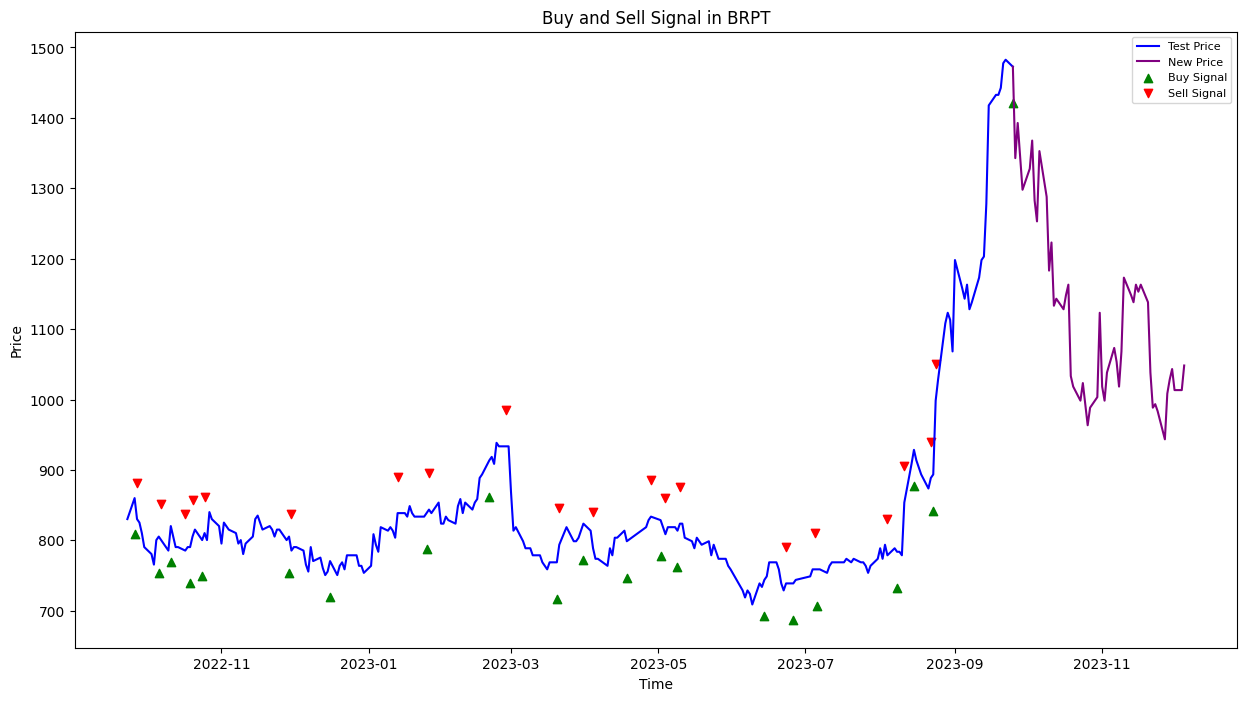

In [221]:
padding = (test_vis['close'].max() - test_vis['close'].min()) / 15

buy_signal = df_result.loc[buy_index_list]
sell_signal = df_result.loc[sell_index_list]


plt.figure(figsize=(15, 8))
plt.plot(test_vis.index, test_vis["close"], color='blue')
plt.plot(new_vis.index, new_vis["close"], color='purple')
plt.scatter(buy_signal['datetime'], buy_signal["close"] - padding, color='green', marker="^")
plt.scatter(sell_signal['datetime'], sell_signal["close"] + padding, color='red', marker="v")
plt.legend(['Test Price', 'New Price','Buy Signal', 'Sell Signal'], loc='upper right', fontsize=8)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'Buy and Sell Signal in {EMITEN}')
plt.show()